# Data Analysis:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import StringIO
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [3]:
with open(os.path.abspath('/content/drive/MyDrive/Datasets-Veltris/machinegenclf/subtaskB_train.jsonl'), 'rb') as f:
    train_data = pd.read_json(f, lines=True)
with open(os.path.abspath('/content/drive/MyDrive/Datasets-Veltris/machinegenclf/subtaskB_dev.jsonl'), 'rb') as f:
    dev_data = pd.read_json(f, lines=True)

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
train_data.head(10)

,text,model,source,label,id
0,Forza Motorsport is a popular racing game that...,chatGPT,wikihow,1,0
1,Buying Virtual Console games for your Nintendo...,chatGPT,wikihow,1,1
2,Windows NT 4.0 was a popular operating system ...,chatGPT,wikihow,1,2
3,How to Make Perfume\n\nPerfume is a great way ...,chatGPT,wikihow,1,3
4,How to Convert Song Lyrics to a Song'\n\nConve...,chatGPT,wikihow,1,4
5,How to Fix a Broken Window in a Wooden Frame\n...,chatGPT,wikihow,1,5
6,Publishing your WordPress theme on Themeforest...,chatGPT,wikihow,1,6
7,Building a Railroad Tie Retaining Wall can be ...,chatGPT,wikihow,1,7
8,Teaching your dog new tricks is a great way to...,chatGPT,wikihow,1,8
9,Remote Desktop is a useful tool that allows yo...,chatGPT,wikihow,1,9


In [16]:
train_data.label.unique()

array([1, 0, 2, 3, 4, 5])

In [6]:
train_data.shape

(71027, 5)

In [7]:
train_data.model.value_counts(dropna=False, normalize=True)

model
davinci    0.168936
bloomz     0.168922
human      0.168908
chatGPT    0.168879
dolly      0.164754
cohere     0.159601
Name: proportion, dtype: float64

In [8]:
dev_data.model.value_counts(dropna=False, normalize=True)

model
chatGPT    0.166667
human      0.166667
davinci    0.166667
cohere     0.166667
bloomz     0.166667
dolly      0.166667
Name: proportion, dtype: float64

In [9]:
id2label = {0: 'human', 1: 'chatGPT', 2: 'cohere', 3: 'davinci', 4: 'bloomz', 5: 'dolly'}
label2id = {'human': 0, 'chatGPT': 1,'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}

# Preprocessing for Analysis:

In [ ]:
# removing emojis and links:

import re

def remove_emojis_links(df, column_name):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    link_pattern = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")

    emojis_found = []
    links_found = []

    for index, row in df.iterrows():
        emojis = emoji_pattern.findall(row[column_name])
        if emojis:
            emojis_found.append((index, emojis))
            # Remove emojis from the text
            df.at[index, column_name] = emoji_pattern.sub('', row[column_name])

        links = link_pattern.findall(row[column_name])
        if links:
            links_found.append((index, links))
            # Remove links from the text
            df.at[index, column_name] = link_pattern.sub('', row[column_name])

    return emojis_found, links_found

# Example usage:
emojis, links = remove_emojis_links(train_data, 'text')

In [ ]:
def find_dates_in_column(column):
  date_pattern = r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b|\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2},?\s+\d{4}\b|\b\d{1,2}\s+(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{4}\b|\b\d{1,2}\s+(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2}\b'
  all_dates = []

  for text in enumerate(column):
    dates = re.findall(date_pattern, str(text))
    all_dates.extend(dates)
  return all_dates

dates_found = find_dates_in_column(train_data['text'])
print("Dates found in the column:", dates_found)

In [48]:
# removing punctuations and tokenizing:
sep = '|'
punctuation_chars = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
mapping_table = str.maketrans(dict.fromkeys(punctuation_chars, ''))
train_data['no_punc'] = train_data['text'].apply(lambda x: sep.join(x.translate(mapping_table).split()).split(sep))
train_data.head()

,text,model,source,label,id,no_punc
0,Forza Motorsport is a popular racing game that...,chatGPT,wikihow,1,0,"[Forza, Motorsport, is, a, popular, racing, ga..."
1,Buying Virtual Console games for your Nintendo...,chatGPT,wikihow,1,1,"[Buying, Virtual, Console, games, for, your, N..."
2,Windows NT 4.0 was a popular operating system ...,chatGPT,wikihow,1,2,"[Windows, NT, 40, was, a, popular, operating, ..."
3,How to Make Perfume\n\nPerfume is a great way ...,chatGPT,wikihow,1,3,"[How, to, Make, Perfume, Perfume, is, a, great..."
4,How to Convert Song Lyrics to a Song'\n\nConve...,chatGPT,wikihow,1,4,"[How, to, Convert, Song, Lyrics, to, a, Song, ..."


In [49]:
# Converting to Lower Case:
train_data['lower'] = train_data['no_punc'].apply(lambda x: [word.lower() for word in x])
train_data.head()

,text,model,source,label,id,no_punc,lower
0,Forza Motorsport is a popular racing game that...,chatGPT,wikihow,1,0,"[Forza, Motorsport, is, a, popular, racing, ga...","[forza, motorsport, is, a, popular, racing, ga..."
1,Buying Virtual Console games for your Nintendo...,chatGPT,wikihow,1,1,"[Buying, Virtual, Console, games, for, your, N...","[buying, virtual, console, games, for, your, n..."
2,Windows NT 4.0 was a popular operating system ...,chatGPT,wikihow,1,2,"[Windows, NT, 40, was, a, popular, operating, ...","[windows, nt, 40, was, a, popular, operating, ..."
3,How to Make Perfume\n\nPerfume is a great way ...,chatGPT,wikihow,1,3,"[How, to, Make, Perfume, Perfume, is, a, great...","[how, to, make, perfume, perfume, is, a, great..."
4,How to Convert Song Lyrics to a Song'\n\nConve...,chatGPT,wikihow,1,4,"[How, to, Convert, Song, Lyrics, to, a, Song, ...","[how, to, convert, song, lyrics, to, a, song, ..."


In [50]:
# removing stop words:
stop_words = set(stopwords.words('english'))
train_data['stopwords_removed'] = train_data['lower'].apply(lambda x: [word for word in x if word not in stop_words])
train_data.head()

,text,model,source,label,id,no_punc,lower,stopwords_removed
0,Forza Motorsport is a popular racing game that...,chatGPT,wikihow,1,0,"[Forza, Motorsport, is, a, popular, racing, ga...","[forza, motorsport, is, a, popular, racing, ga...","[forza, motorsport, popular, racing, game, pro..."
1,Buying Virtual Console games for your Nintendo...,chatGPT,wikihow,1,1,"[Buying, Virtual, Console, games, for, your, N...","[buying, virtual, console, games, for, your, n...","[buying, virtual, console, games, nintendo, wi..."
2,Windows NT 4.0 was a popular operating system ...,chatGPT,wikihow,1,2,"[Windows, NT, 40, was, a, popular, operating, ...","[windows, nt, 40, was, a, popular, operating, ...","[windows, nt, 40, popular, operating, system, ..."
3,How to Make Perfume\n\nPerfume is a great way ...,chatGPT,wikihow,1,3,"[How, to, Make, Perfume, Perfume, is, a, great...","[how, to, make, perfume, perfume, is, a, great...","[make, perfume, perfume, great, way, enhance, ..."
4,How to Convert Song Lyrics to a Song'\n\nConve...,chatGPT,wikihow,1,4,"[How, to, Convert, Song, Lyrics, to, a, Song, ...","[how, to, convert, song, lyrics, to, a, song, ...","[convert, song, lyrics, song, converting, song..."


In [51]:
# give pos tags:

train_data['pos_tags'] = train_data['stopwords_removed'].apply(nltk.tag.pos_tag)
train_data.head()

,text,model,source,label,id,no_punc,lower,stopwords_removed,pos_tags
0,Forza Motorsport is a popular racing game that...,chatGPT,wikihow,1,0,"[Forza, Motorsport, is, a, popular, racing, ga...","[forza, motorsport, is, a, popular, racing, ga...","[forza, motorsport, popular, racing, game, pro...","[(forza, NN), (motorsport, NN), (popular, JJ),..."
1,Buying Virtual Console games for your Nintendo...,chatGPT,wikihow,1,1,"[Buying, Virtual, Console, games, for, your, N...","[buying, virtual, console, games, for, your, n...","[buying, virtual, console, games, nintendo, wi...","[(buying, VBG), (virtual, JJ), (console, JJ), ..."
2,Windows NT 4.0 was a popular operating system ...,chatGPT,wikihow,1,2,"[Windows, NT, 40, was, a, popular, operating, ...","[windows, nt, 40, was, a, popular, operating, ...","[windows, nt, 40, popular, operating, system, ...","[(windows, NNS), (nt, VBP), (40, CD), (popular..."
3,How to Make Perfume\n\nPerfume is a great way ...,chatGPT,wikihow,1,3,"[How, to, Make, Perfume, Perfume, is, a, great...","[how, to, make, perfume, perfume, is, a, great...","[make, perfume, perfume, great, way, enhance, ...","[(make, VB), (perfume, NN), (perfume, NN), (gr..."
4,How to Convert Song Lyrics to a Song'\n\nConve...,chatGPT,wikihow,1,4,"[How, to, Convert, Song, Lyrics, to, a, Song, ...","[how, to, convert, song, lyrics, to, a, song, ...","[convert, song, lyrics, song, converting, song...","[(convert, NN), (song, NN), (lyrics, NNS), (so..."


In [52]:
# add wordnet pos tags:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
train_data['wordnet_pos'] = train_data['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
train_data.head()

,text,model,source,label,id,no_punc,lower,stopwords_removed,pos_tags,wordnet_pos
0,Forza Motorsport is a popular racing game that...,chatGPT,wikihow,1,0,"[Forza, Motorsport, is, a, popular, racing, ga...","[forza, motorsport, is, a, popular, racing, ga...","[forza, motorsport, popular, racing, game, pro...","[(forza, NN), (motorsport, NN), (popular, JJ),...","[(forza, n), (motorsport, n), (popular, a), (r..."
1,Buying Virtual Console games for your Nintendo...,chatGPT,wikihow,1,1,"[Buying, Virtual, Console, games, for, your, N...","[buying, virtual, console, games, for, your, n...","[buying, virtual, console, games, nintendo, wi...","[(buying, VBG), (virtual, JJ), (console, JJ), ...","[(buying, v), (virtual, a), (console, a), (gam..."
2,Windows NT 4.0 was a popular operating system ...,chatGPT,wikihow,1,2,"[Windows, NT, 40, was, a, popular, operating, ...","[windows, nt, 40, was, a, popular, operating, ...","[windows, nt, 40, popular, operating, system, ...","[(windows, NNS), (nt, VBP), (40, CD), (popular...","[(windows, n), (nt, v), (40, n), (popular, a),..."
3,How to Make Perfume\n\nPerfume is a great way ...,chatGPT,wikihow,1,3,"[How, to, Make, Perfume, Perfume, is, a, great...","[how, to, make, perfume, perfume, is, a, great...","[make, perfume, perfume, great, way, enhance, ...","[(make, VB), (perfume, NN), (perfume, NN), (gr...","[(make, v), (perfume, n), (perfume, n), (great..."
4,How to Convert Song Lyrics to a Song'\n\nConve...,chatGPT,wikihow,1,4,"[How, to, Convert, Song, Lyrics, to, a, Song, ...","[how, to, convert, song, lyrics, to, a, song, ...","[convert, song, lyrics, song, converting, song...","[(convert, NN), (song, NN), (lyrics, NNS), (so...","[(convert, n), (song, n), (lyrics, n), (song, ..."


In [53]:
# lemmatization:
wnl = WordNetLemmatizer()
train_data['lemmatized'] = train_data['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
train_data.head()

,text,model,source,label,id,no_punc,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,Forza Motorsport is a popular racing game that...,chatGPT,wikihow,1,0,"[Forza, Motorsport, is, a, popular, racing, ga...","[forza, motorsport, is, a, popular, racing, ga...","[forza, motorsport, popular, racing, game, pro...","[(forza, NN), (motorsport, NN), (popular, JJ),...","[(forza, n), (motorsport, n), (popular, a), (r...","[forza, motorsport, popular, racing, game, pro..."
1,Buying Virtual Console games for your Nintendo...,chatGPT,wikihow,1,1,"[Buying, Virtual, Console, games, for, your, N...","[buying, virtual, console, games, for, your, n...","[buying, virtual, console, games, nintendo, wi...","[(buying, VBG), (virtual, JJ), (console, JJ), ...","[(buying, v), (virtual, a), (console, a), (gam...","[buy, virtual, console, game, nintendo, wii, f..."
2,Windows NT 4.0 was a popular operating system ...,chatGPT,wikihow,1,2,"[Windows, NT, 40, was, a, popular, operating, ...","[windows, nt, 40, was, a, popular, operating, ...","[windows, nt, 40, popular, operating, system, ...","[(windows, NNS), (nt, VBP), (40, CD), (popular...","[(windows, n), (nt, v), (40, n), (popular, a),...","[window, nt, 40, popular, operating, system, b..."
3,How to Make Perfume\n\nPerfume is a great way ...,chatGPT,wikihow,1,3,"[How, to, Make, Perfume, Perfume, is, a, great...","[how, to, make, perfume, perfume, is, a, great...","[make, perfume, perfume, great, way, enhance, ...","[(make, VB), (perfume, NN), (perfume, NN), (gr...","[(make, v), (perfume, n), (perfume, n), (great...","[make, perfume, perfume, great, way, enhance, ..."
4,How to Convert Song Lyrics to a Song'\n\nConve...,chatGPT,wikihow,1,4,"[How, to, Convert, Song, Lyrics, to, a, Song, ...","[how, to, convert, song, lyrics, to, a, song, ...","[convert, song, lyrics, song, converting, song...","[(convert, NN), (song, NN), (lyrics, NNS), (so...","[(convert, n), (song, n), (lyrics, n), (song, ...","[convert, song, lyric, song, convert, song, ly..."


# emojis and links analysis:

In [ ]:
import pandas as pd
import re

def separate_emojis_links(df, column_name):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002500-\U00002BEF"  # chinese char
                              u"\U00002702-\U000027B0"
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              u"\U0001f926-\U0001f937"
                              u"\U00010000-\U0010ffff"
                              u"\u2640-\u2642"
                              u"\u2600-\u2B55"
                              u"\u200d"
                              u"\u23cf"
                              u"\u23e9"
                              u"\u231a"
                              u"\ufe0f"  # dingbats
                              u"\u3030"
                              "]+", flags=re.UNICODE)
  link_pattern = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")

  human_emojis = []
  human_links = []
  machine_emojis = []
  machine_links = []

  for index, row in df.iterrows():
      emojis = emoji_pattern.findall(row[column_name])
      links = link_pattern.findall(row[column_name])
      if row['label'] == 0:
          if emojis:
              human_emojis.append((index, emojis))
          if links:
              human_links.append((index, links))
      else:
          if emojis:
              machine_emojis.append((index, emojis))
          if links:
              machine_links.append((index, links))

  return human_emojis, human_links, machine_emojis, machine_links

human_emojis, human_links, machine_emojis, machine_links = separate_emojis_links(train_data, 'text')


In [ ]:
def print_emojis_links(emojis, links):
  print("Emojis found:")
  for index, emojis_list in emojis:
    print(f"At index {index}: {emojis_list}")

  print("\nLinks found:")
  for index, links_list in links:
      print(f"At index {index}: {links_list}")

In [ ]:
print("Human Text Emojis and Links: \n")
print_emojis_links(human_emojis, human_links)

In [ ]:
print("Machine Text Emojis and Links: \n")
print_emojis_links(machine_emojis, machine_links)

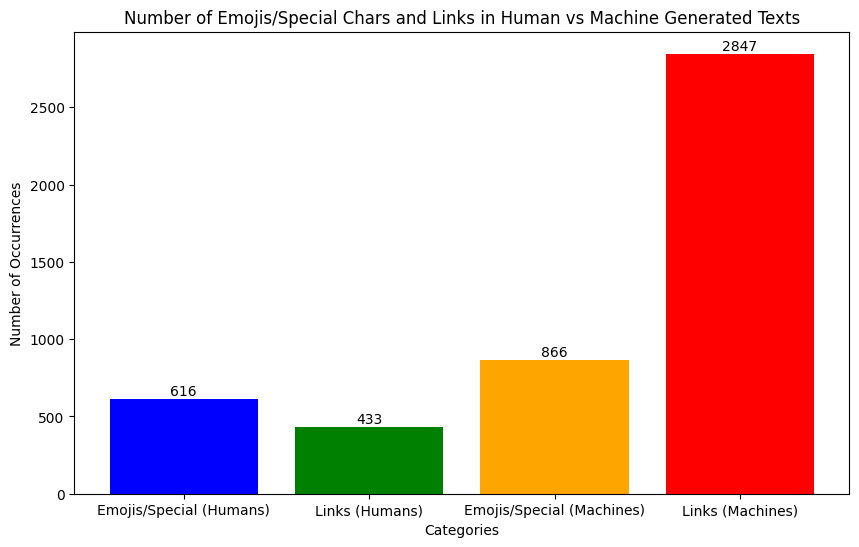

In [ ]:
import matplotlib.pyplot as plt

num_human_emojis = sum(len(emojis[1]) for emojis in human_emojis)
num_human_links = sum(len(links[1]) for links in human_links)
num_machine_emojis = sum(len(emojis[1]) for emojis in machine_emojis)
num_machine_links = sum(len(links[1]) for links in machine_links)

categories = ['Emojis/Special (Humans)', 'Links (Humans)', 'Emojis/Special (Machines)', 'Links (Machines)']
values = [num_human_emojis, num_human_links, num_machine_emojis, num_machine_links]
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=['blue', 'green', 'orange', 'red'])
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, value, ha='center', va='bottom')
plt.xlabel('Categories')
plt.ylabel('Number of Occurrences')
plt.title('Number of Emojis/Special Chars and Links in Human vs Machine Generated Texts')
plt.show()

# Analysis:

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.1 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
from collections import Counter
from textblob import TextBlob
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [ ]:
train_data['lemma_str'] = [' '.join(map(str,l)) for l in train_data['lemmatized']]
train_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,model,source,label,id,no_punc,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,Forza Motorsport is a popular racing game that provides players with the ability to race on vari...,chatGPT,wikihow,1,0,"[Forza, Motorsport, is, a, popular, racing, game, that, provides, players, with, the, ability, t...","[forza, motorsport, is, a, popular, racing, game, that, provides, players, with, the, ability, t...","[forza, motorsport, popular, racing, game, provides, players, ability, race, various, tracks, di...","[(forza, NN), (motorsport, NN), (popular, JJ), (racing, NN), (game, NN), (provides, VBZ), (playe...","[(forza, n), (motorsport, n), (popular, a), (racing, n), (game, n), (provides, v), (players, n),...","[forza, motorsport, popular, racing, game, provide, player, ability, race, various, track, diffe...",forza motorsport popular racing game provide player ability race various track different vehicle...
1,Buying Virtual Console games for your Nintendo Wii is a fun and easy process that can net you so...,chatGPT,wikihow,1,1,"[Buying, Virtual, Console, games, for, your, Nintendo, Wii, is, a, fun, and, easy, process, that...","[buying, virtual, console, games, for, your, nintendo, wii, is, a, fun, and, easy, process, that...","[buying, virtual, console, games, nintendo, wii, fun, easy, process, net, classic, games, play, ...","[(buying, VBG), (virtual, JJ), (console, JJ), (games, NNS), (nintendo, JJ), (wii, JJ), (fun, NN)...","[(buying, v), (virtual, a), (console, a), (games, n), (nintendo, a), (wii, a), (fun, n), (easy, ...","[buy, virtual, console, game, nintendo, wii, fun, easy, process, net, classic, game, play, conso...",buy virtual console game nintendo wii fun easy process net classic game play console simple step...
2,"Windows NT 4.0 was a popular operating system back in the day, and some still prefer it for use ...",chatGPT,wikihow,1,2,"[Windows, NT, 40, was, a, popular, operating, system, back, in, the, day, and, some, still, pref...","[windows, nt, 40, was, a, popular, operating, system, back, in, the, day, and, some, still, pref...","[windows, nt, 40, popular, operating, system, back, day, still, prefer, use, today, youre, looki...","[(windows, NNS), (nt, VBP), (40, CD), (popular, JJ), (operating, NN), (system, NN), (back, RB), ...","[(windows, n), (nt, v), (40, n), (popular, a), (operating, n), (system, n), (back, r), (day, n),...","[window, nt, 40, popular, operating, system, back, day, still, prefer, use, today, youre, look, ...",window nt 40 popular operating system back day still prefer use today youre look install window ...
3,How to Make Perfume\n\nPerfume is a great way to enhance your personal scent and create a signat...,chatGPT,wikihow,1,3,"[How, to, Make, Perfume, Perfume, is, a, great, way, to, enhance, your, personal, scent, and, cr...","[how, to, make, perfume, perfume, is, a, great, way, to, enhance, your, personal, scent, and, cr...","[make, perfume, perfume, great, way, enhance, personal, scent, create, signature, fragrance, her...","[(make, VB), (perfume, NN), (perfume, NN), (great, JJ), (way, NN), (enhance, NN), (personal, JJ)...","[(make, v), (perfume, n), (perfume, n), (great, a), (way, n), (enhance, n), (personal, a), (scen...","[make, perfume, perfume, great, way, enhance, personal, scent, create, signature, fragrance, her...",make perfume perfume great way enhance personal scent create signature fragrance here make perfu...
4,How to Convert Song Lyrics to a Song'\n\nConverting your song lyrics into a full-fledged song ca...,chatGPT,wikihow,1,4,"[How, to, Convert, Song, Lyrics, to, a, Song, Converting, your, song, lyrics, into, a, fullfledg...","[how, to, convert, song, lyrics, to, a, song, converting, your, song, lyrics, into, a, fullfledg...","[convert, song, lyrics, song, converting, song, lyrics, fullfledged, song, exciting, fulfilling,...","[(convert, NN), (song, NN), (lyrics, NNS), (song, JJ), (converting, VBG), (song, NN), (lyrics, N...","[(convert, n), (song, n), (ly

In [ ]:
train_data['word_count'] = train_data['lower'].apply(lambda x: len(str(x).split()))
train_data['text_len'] = train_data['text'].astype(str).apply(len)
train_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,model,source,label,id,no_punc,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str,word_count,text_len
0,Forza Motorsport is a popular racing game that provides players with the ability to race on vari...,chatGPT,wikihow,1,0,"[Forza, Motorsport, is, a, popular, racing, game, that, provides, players, with, the, ability, t...","[forza, motorsport, is, a, popular, racing, game, that, provides, players, with, the, ability, t...","[forza, motorsport, popular, racing, game, provides, players, ability, race, various, tracks, di...","[(forza, NN), (motorsport, NN), (popular, JJ), (racing, NN), (game, NN), (provides, VBZ), (playe...","[(forza, n), (motorsport, n), (popular, a), (racing, n), (game, n), (provides, v), (players, n),...","[forza, motorsport, popular, racing, game, provide, player, ability, race, various, track, diffe...",forza motorsport popular racing game provide player ability race various track different vehicle...,407,2244
1,Buying Virtual Console games for your Nintendo Wii is a fun and easy process that can net you so...,chatGPT,wikihow,1,1,"[Buying, Virtual, Console, games, for, your, Nintendo, Wii, is, a, fun, and, easy, process, that...","[buying, virtual, console, games, for, your, nintendo, wii, is, a, fun, and, easy, process, that...","[buying, virtual, console, games, nintendo, wii, fun, easy, process, net, classic, games, play, ...","[(buying, VBG), (virtual, JJ), (console, JJ), (games, NNS), (nintendo, JJ), (wii, JJ), (fun, NN)...","[(buying, v), (virtual, a), (console, a), (games, n), (nintendo, a), (wii, a), (fun, n), (easy, ...","[buy, virtual, console, game, nintendo, wii, fun, easy, process, net, classic, game, play, conso...",buy virtual console game nintendo wii fun easy process net classic game play console simple step...,681,3728
2,"Windows NT 4.0 was a popular operating system back in the day, and some still prefer it for use ...",chatGPT,wikihow,1,2,"[Windows, NT, 40, was, a, popular, operating, system, back, in, the, day, and, some, still, pref...","[windows, nt, 40, was, a, popular, operating, system, back, in, the, day, and, some, still, pref...","[windows, nt, 40, popular, operating, system, back, day, still, prefer, use, today, youre, looki...","[(windows, NNS), (nt, VBP), (40, CD), (popular, JJ), (operating, NN), (system, NN), (back, RB), ...","[(windows, n), (nt, v), (40, n), (popular, a), (operating, n), (system, n), (back, r), (day, n),...","[window, nt, 40, popular, operating, system, back, day, still, prefer, use, today, youre, look, ...",window nt 40 popular operating system back day still prefer use today youre look install window ...,913,5237
3,How to Make Perfume\n\nPerfume is a great way to enhance your personal scent and create a signat...,chatGPT,wikihow,1,3,"[How, to, Make, Perfume, Perfume, is, a, great, way, to, enhance, your, personal, scent, and, cr...","[how, to, make, perfume, perfume, is, a, great, way, to, enhance, your, personal, scent, and, cr...","[make, perfume, perfume, great, way, enhance, personal, scent, create, signature, fragrance, her...","[(make, VB), (perfume, NN), (perfume, NN), (great, JJ), (way, NN), (enhance, NN), (personal, JJ)...","[(make, v), (perfume, n), (perfume, n), (great, a), (way, n), (enhance, n), (personal, a), (scen...","[make, perfume, perfume, great, way, enhance, personal, scent, create, signature, fragrance, her...",make perfume perfume great way enhance personal scent create signature fragrance here make perfu...,797,4729
4,How to Convert Song Lyrics to a Song'\n\nConverting your song lyrics into a full-fledged song ca...,chatGPT,wikihow,1,4,"[How, to, Convert, Song, Lyrics, to, a, Song, Converting, your, song, lyrics, into, a, fullfledg...","[how, to, convert, song, lyrics, to, a, song, converting, your, song, lyrics, into, a, fullfledg...","[convert, song, lyrics, song, converting, song, lyrics, fullfledged, song, exciting, fulfilling,...","[(convert, NN), (song, NN), (lyrics, NNS), (song, JJ), (converting, VBG), (

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


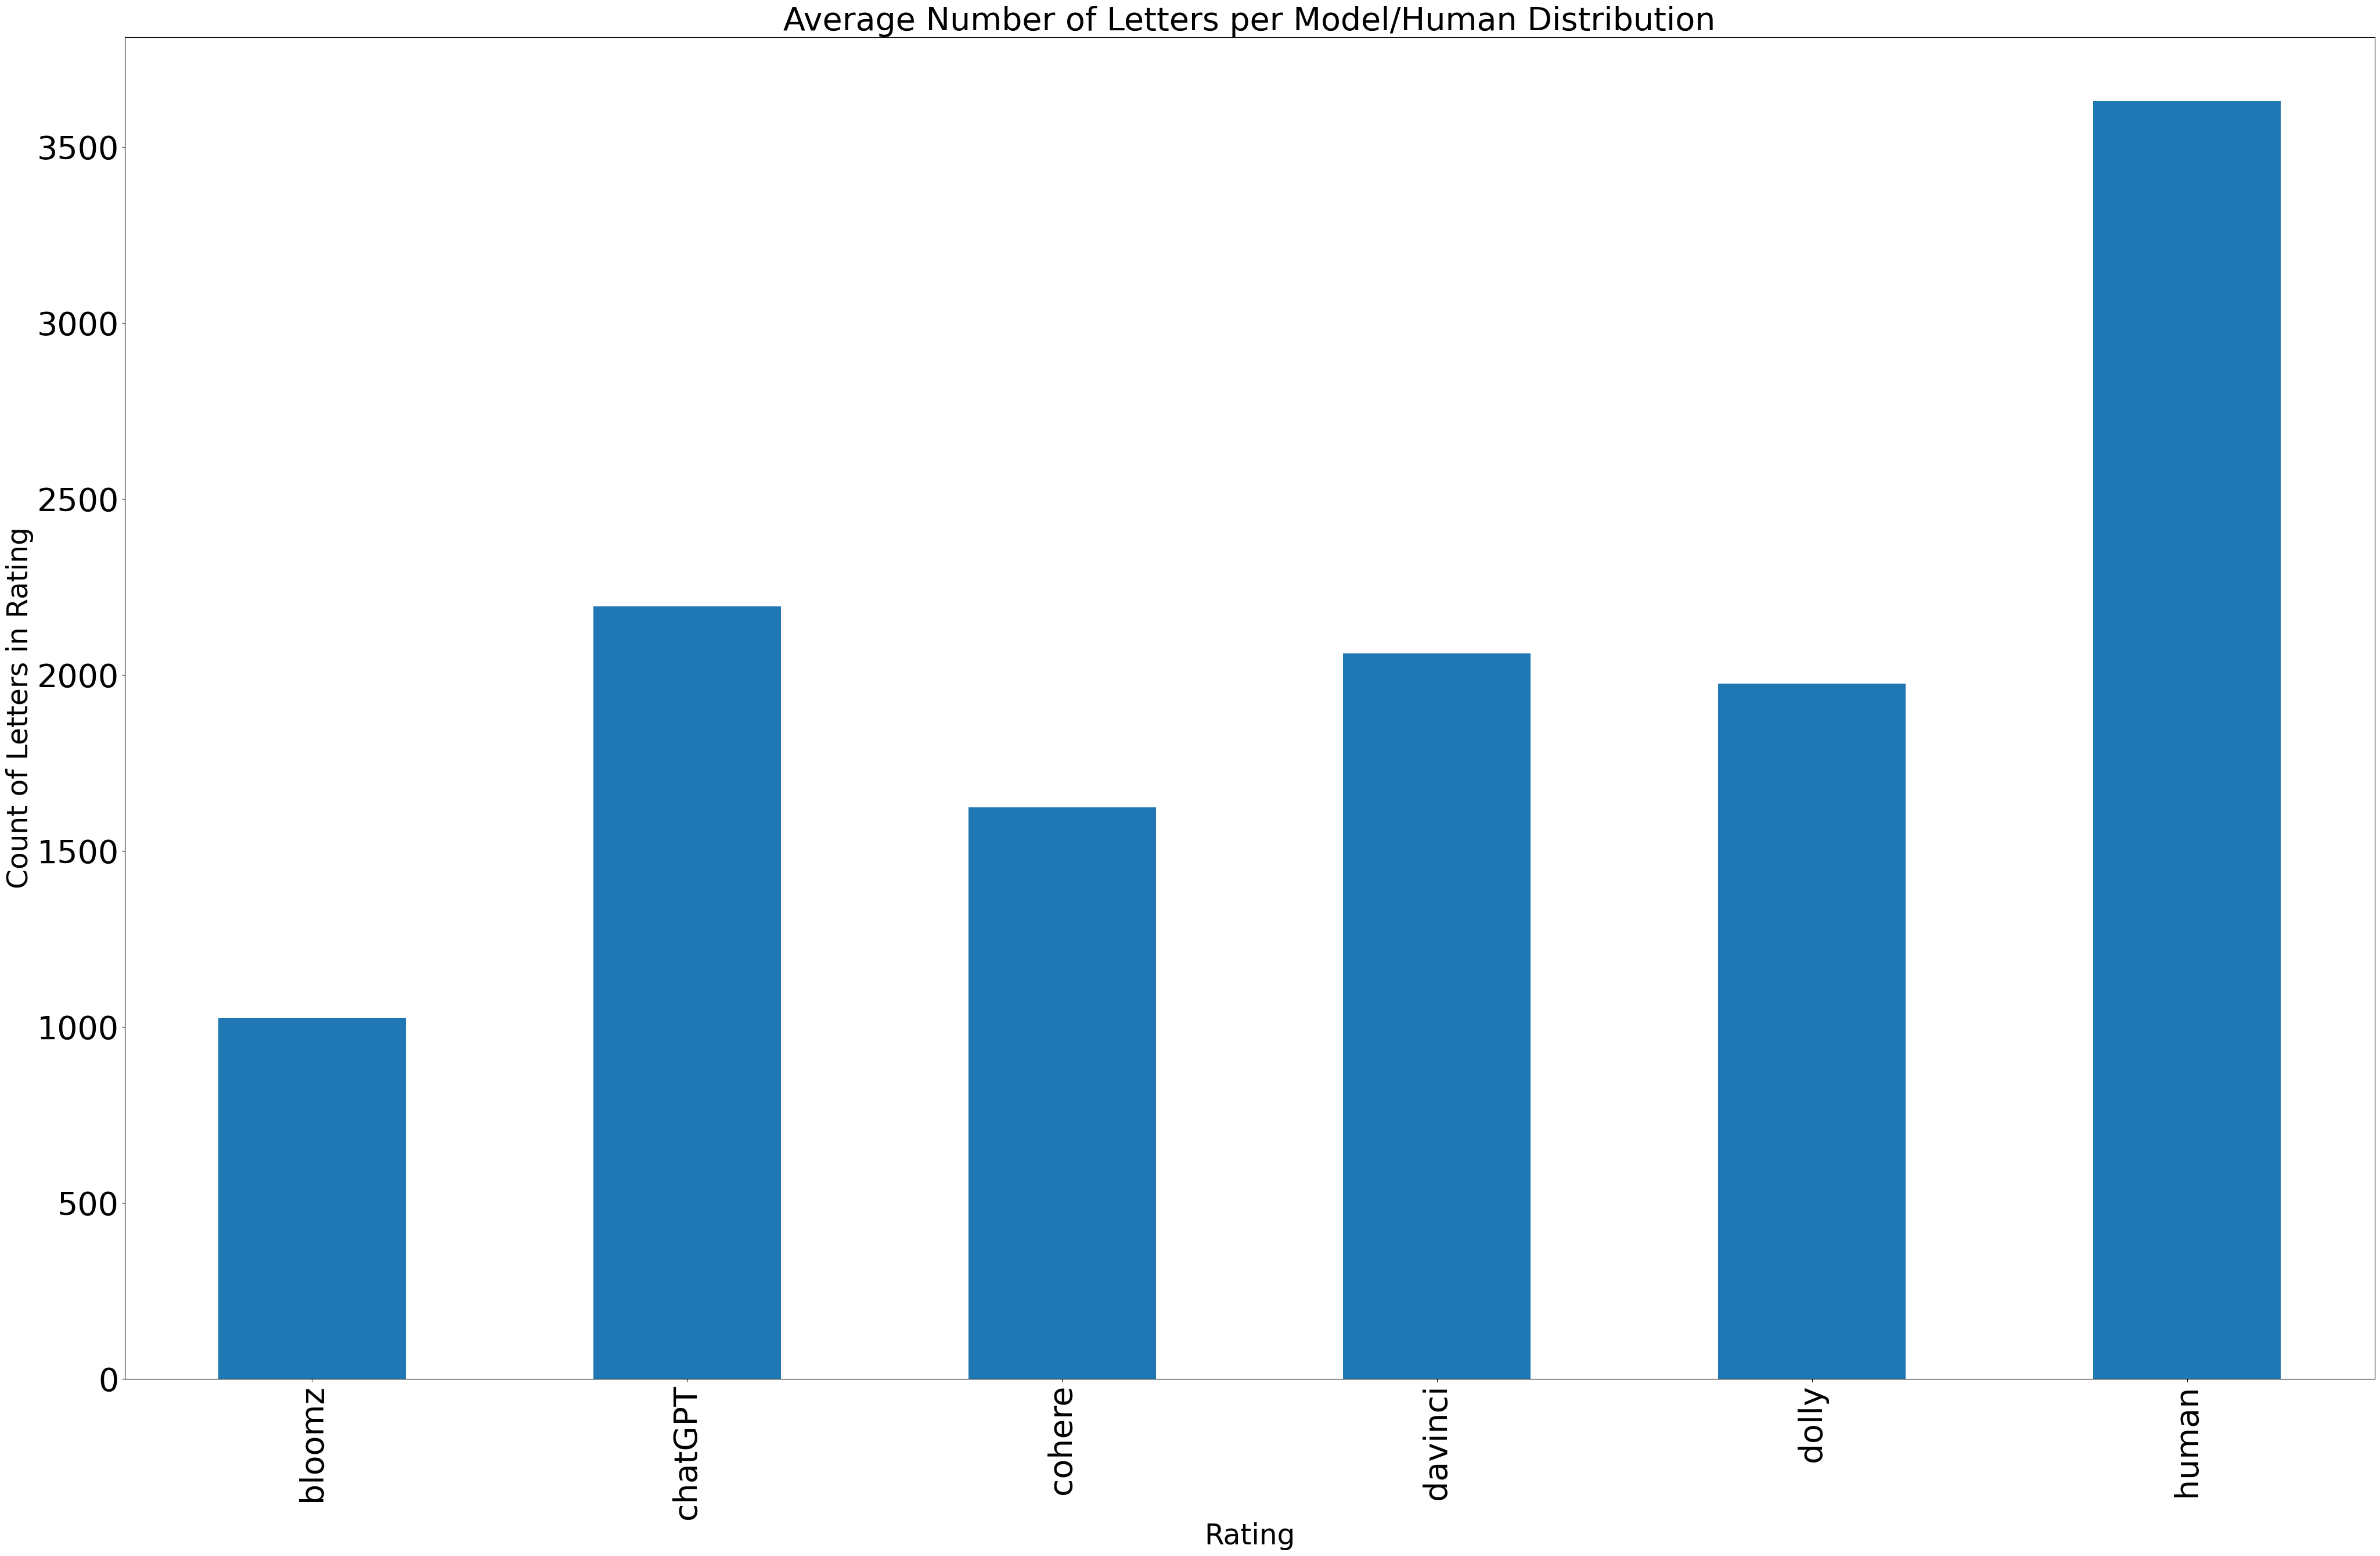

In [ ]:
letter_avg = train_data.groupby('model')['text_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Model/Human Distribution', fontsize=40)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


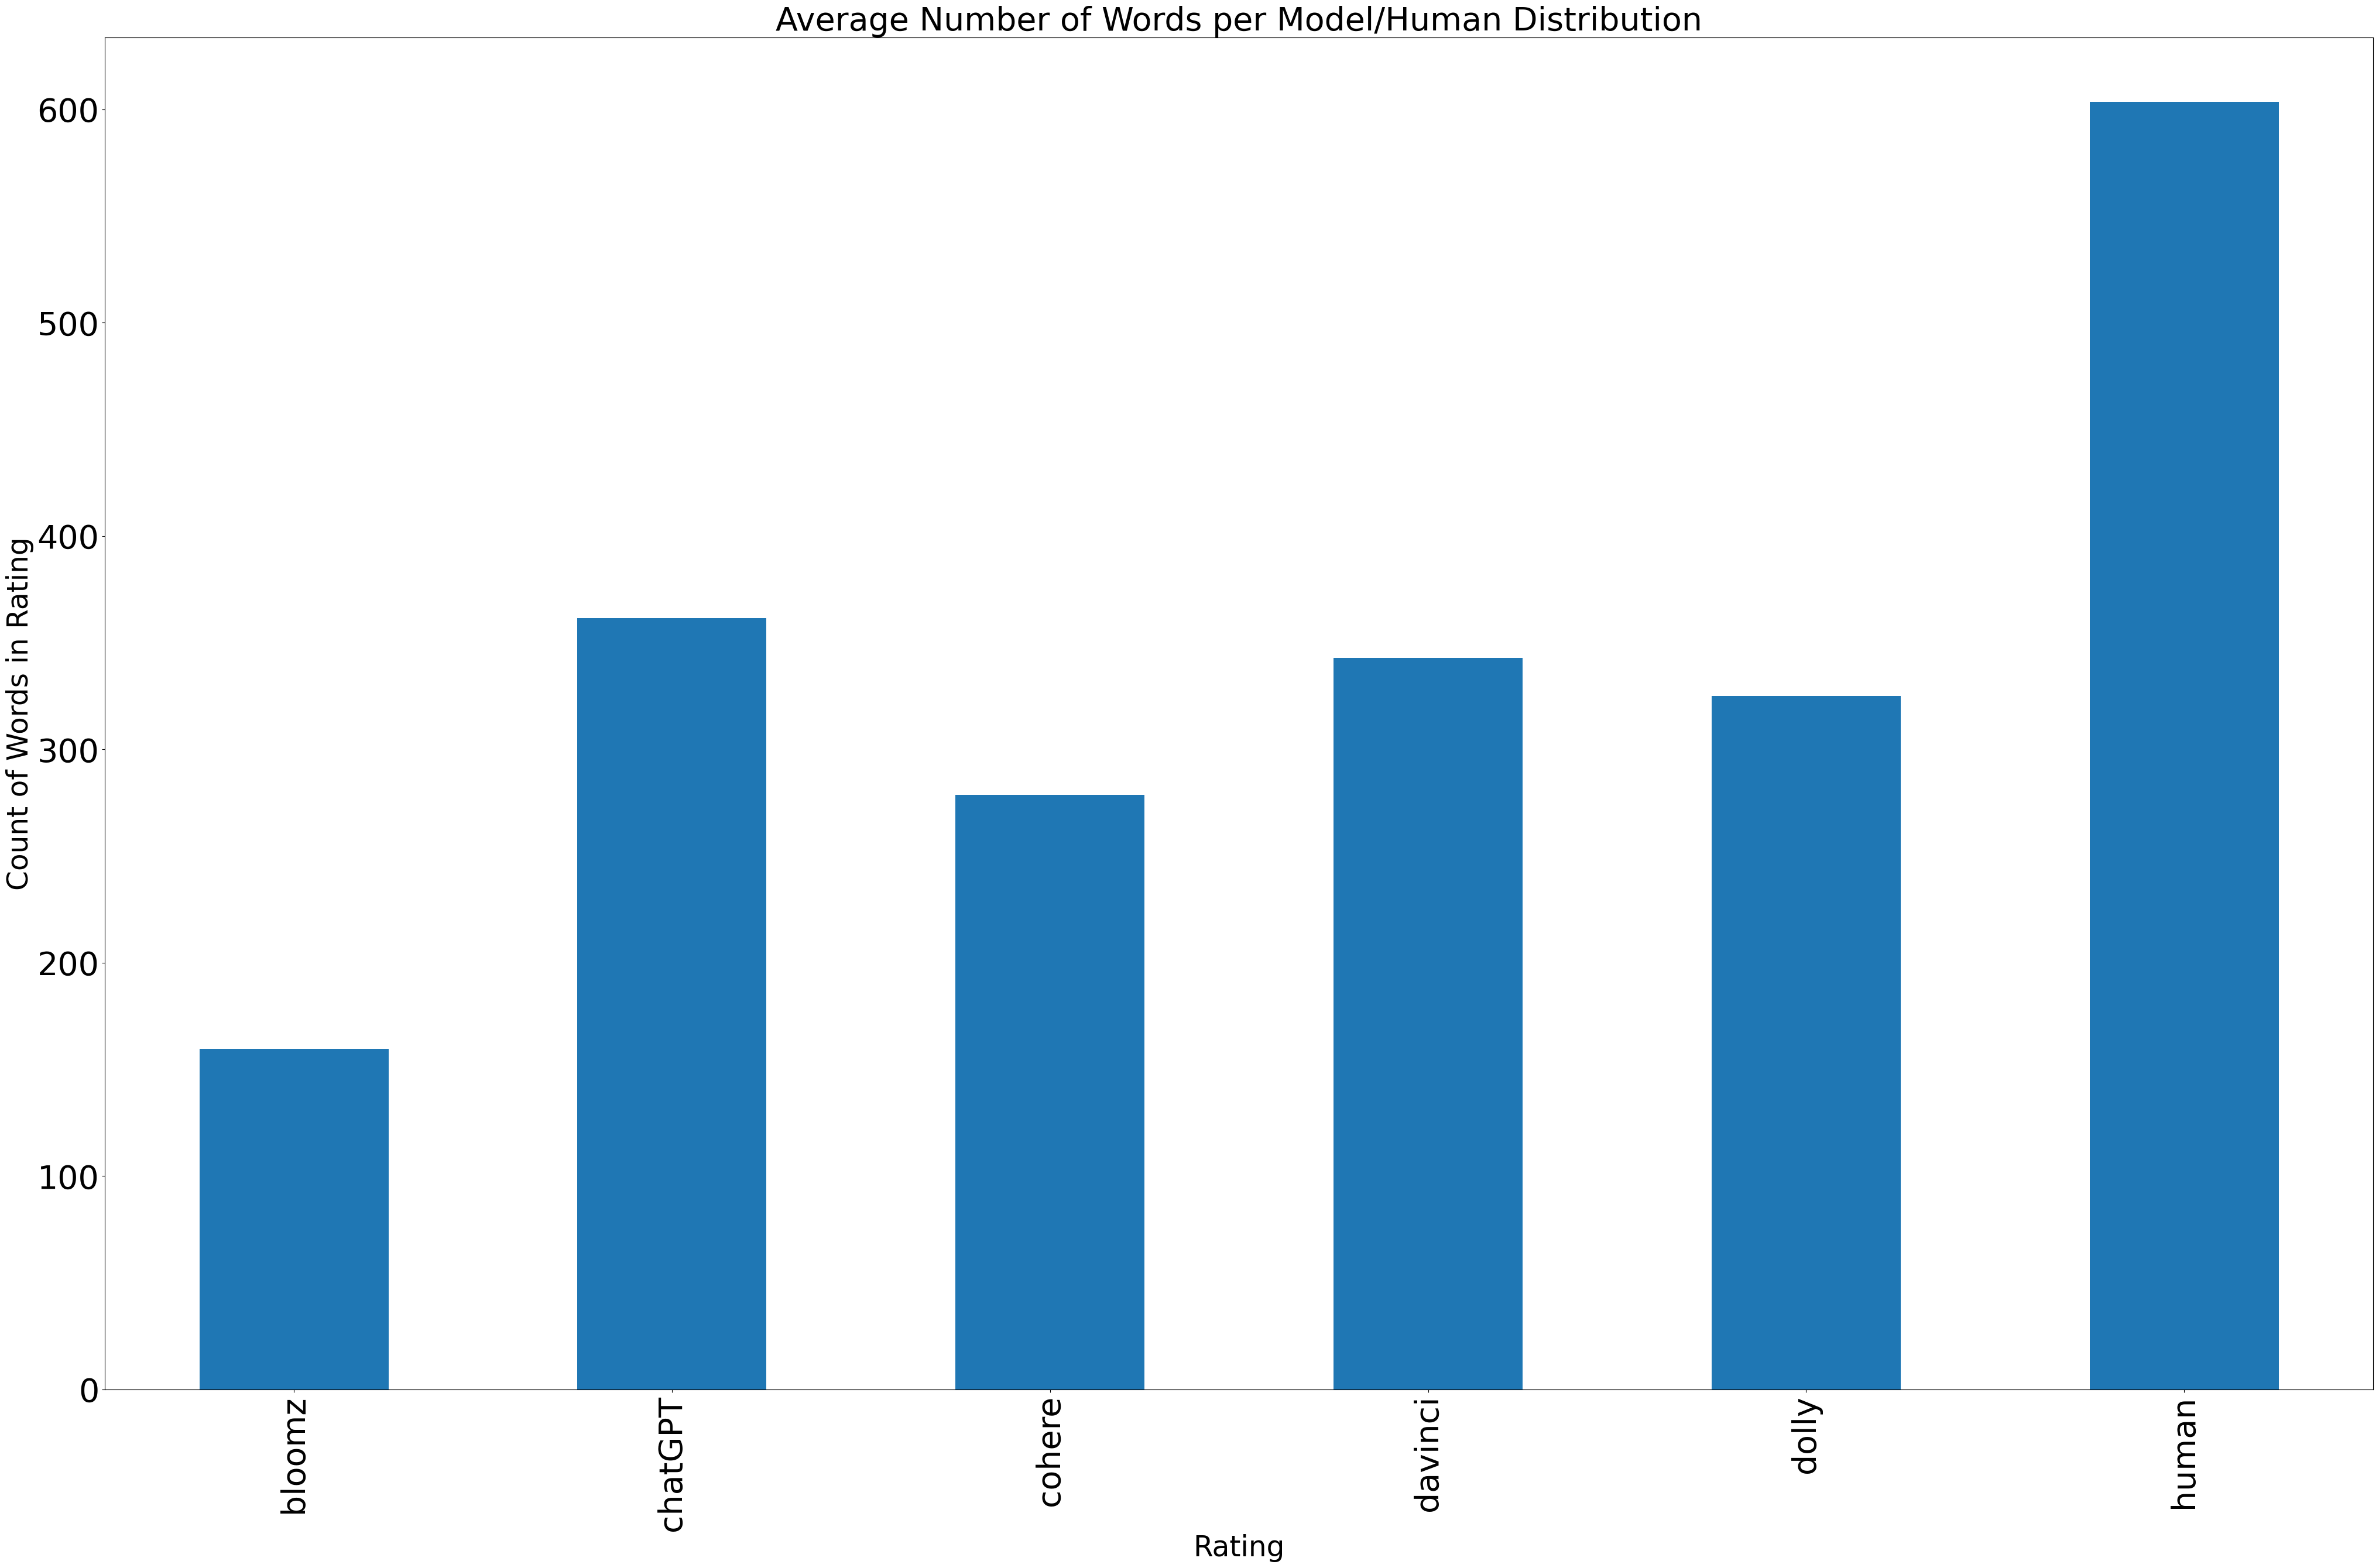

In [ ]:
word_avg = train_data.groupby('model')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Model/Human Distribution', fontsize=40)
plt.show()

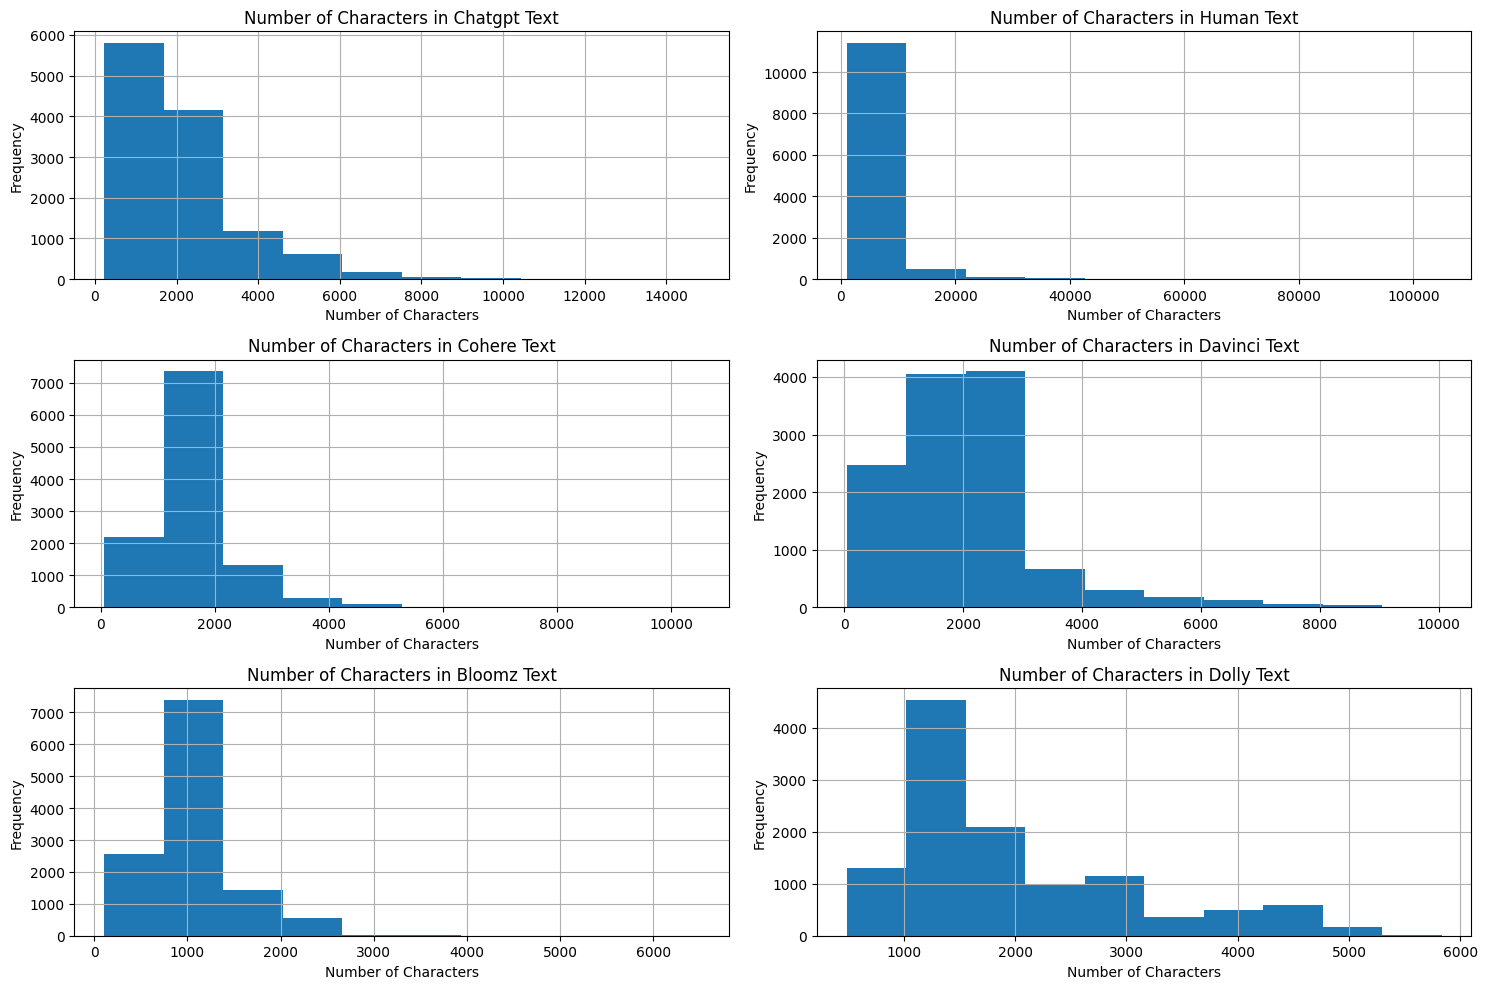

In [41]:
import matplotlib.pyplot as plt

categories = train_data['model'].unique()
num_rows = (len(categories) + 1) // 2  # Add 1 and use integer division to ensure at least one row
num_cols = 2  # Two columns in each row
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
if len(categories) == 1:
    axes = axes.reshape(1, 1)
else:
    axes = axes.flatten()
for i, category in enumerate(categories):
    ax = axes[i]
    train_data[train_data['model'] == category]['text'].str.len().hist(ax=ax)
    ax.set_title(f'Number of Characters in {category.capitalize()} Text')
    ax.set_xlabel('Number of Characters')
    ax.set_ylabel('Frequency')
for j in range(len(categories), num_rows * num_cols):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

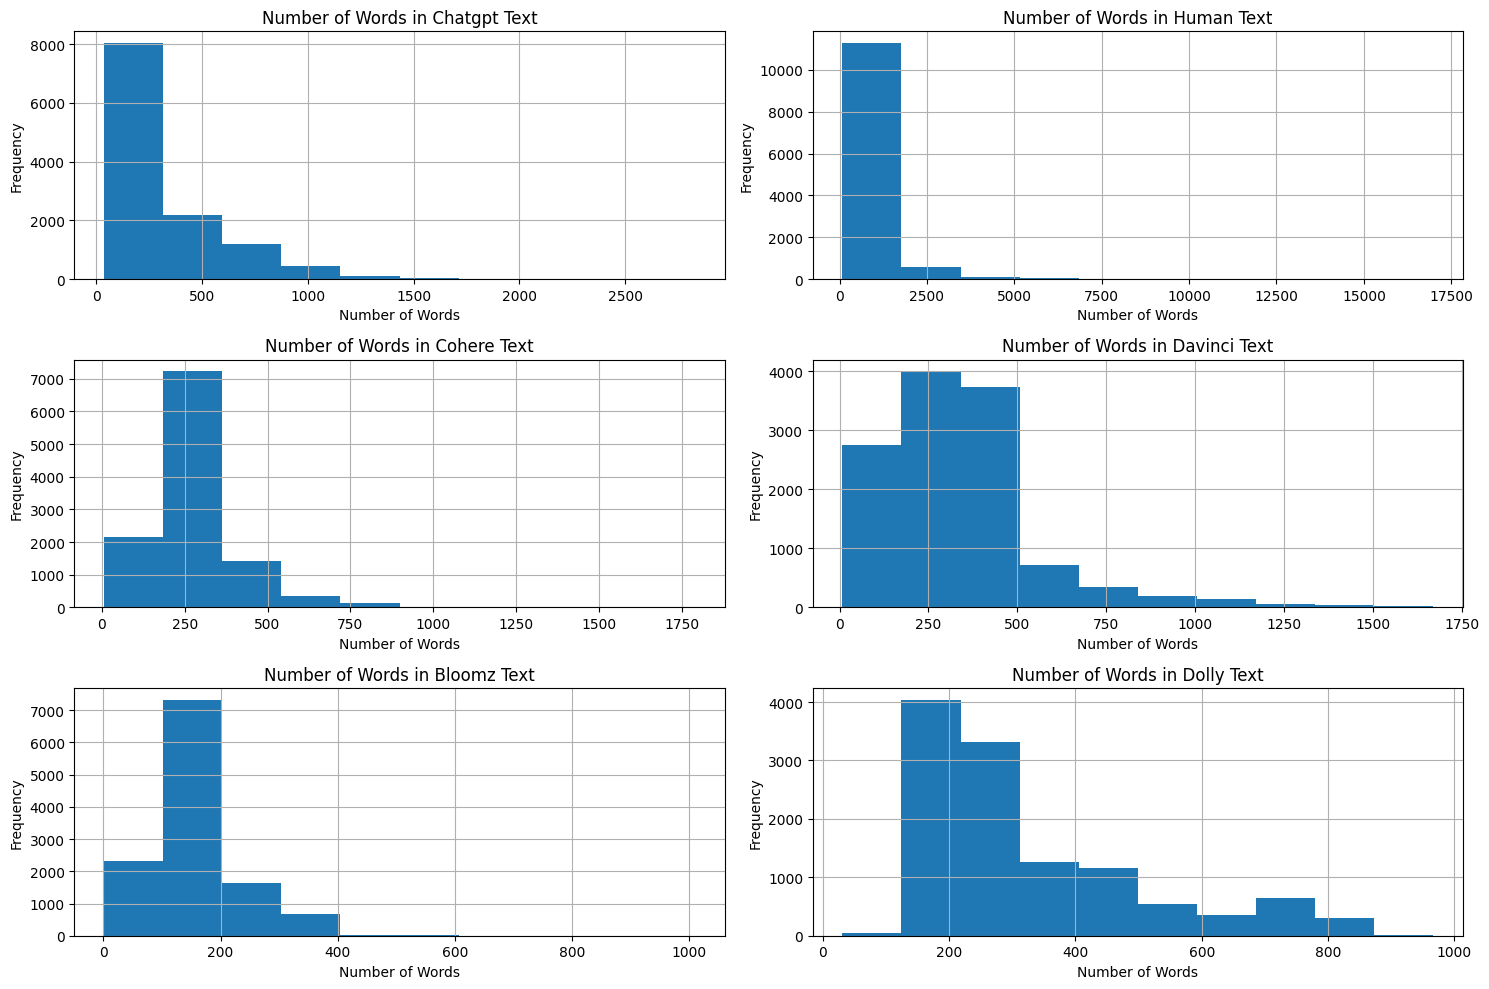

In [44]:
import matplotlib.pyplot as plt

categories = train_data['model'].unique()
num_rows = (len(categories) + 1) // 2  # Add 1 and use integer division to ensure at least one row
num_cols = 2  # Two columns in each row
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
if len(categories) == 1:
    axes = axes.reshape(1, 1)
else:
    axes = axes.flatten()
for i, category in enumerate(categories):
    ax = axes[i]
    train_data[train_data['model'] == category]['text'].str.split().map(lambda x: len(x)).hist(ax=ax)
    ax.set_title(f'Number of Words in {category.capitalize()} Text')
    ax.set_xlabel('Number of Words')
    ax.set_ylabel('Frequency')
for j in range(len(categories), num_rows * num_cols):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

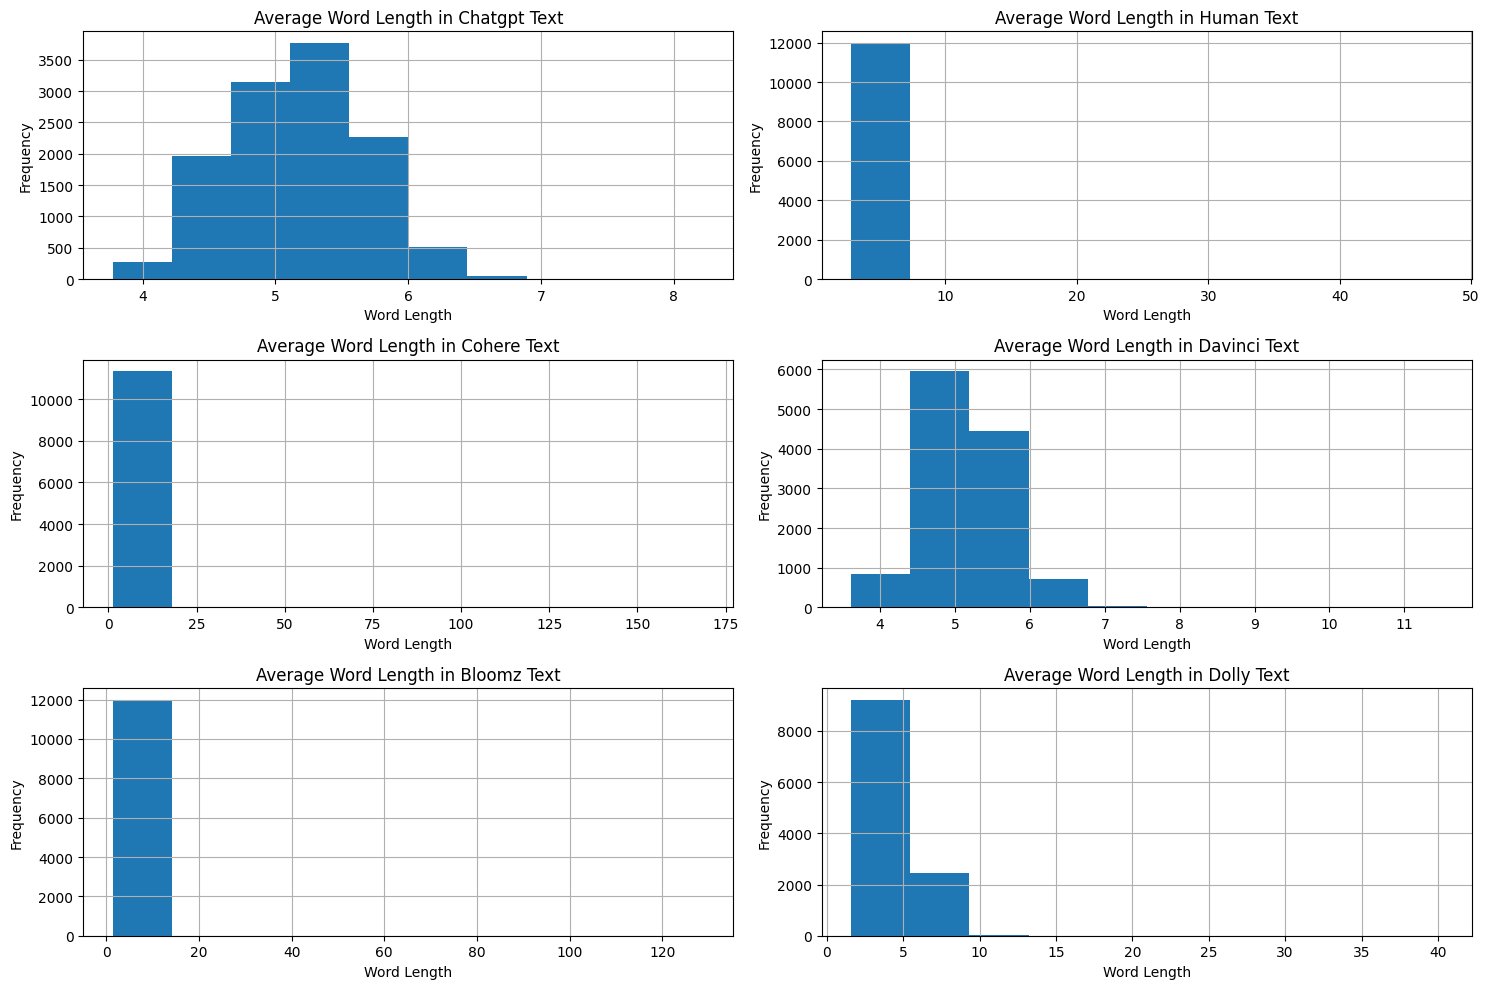

In [47]:
import matplotlib.pyplot as plt

categories = train_data['model'].unique()
num_rows = (len(categories) + 1) // 2  # Add 1 and use integer division to ensure at least one row
num_cols = 2  # Two columns in each row
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
if len(categories) == 1:
    axes = axes.reshape(1, 1)
else:
    axes = axes.flatten()
for i, category in enumerate(categories):
    ax = axes[i]
    train_data[train_data['model'] == category]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(ax=ax)
    ax.set_title(f'Average Word Length in {category.capitalize()} Text')
    ax.set_xlabel('Word Length')
    ax.set_ylabel('Frequency')
for j in range(len(categories), num_rows * num_cols):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

In [143]:
def remove_dates_from_column(text):
  date_pattern = r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b|\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2},?\s+\d{4}\b|\b\d{1,2}\s+(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{4}\b|\b\d{1,2}\s+(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2}\b'
  return re.sub(date_pattern, '', " ".join(text))

In [155]:
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, model,n=2):
    stop=set(stopwords.words('english'))
    text = list(text)
    # text = [remove_dates_from_column(i) for i in text]
    text = [" ".join(i) for i in text]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    plt.title(f'Top 10 Bi-Grams in {model} text')
    plt.show()

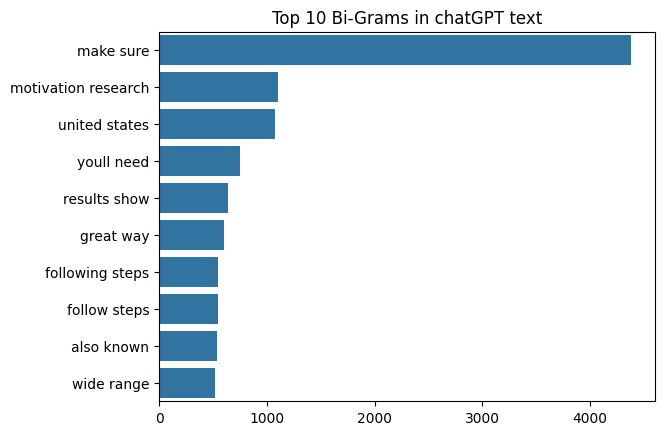

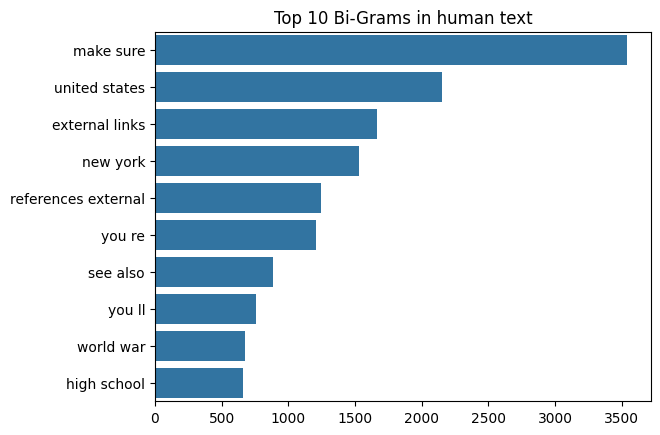

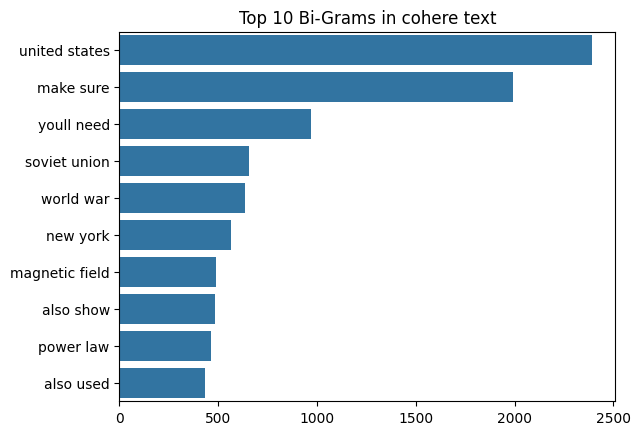

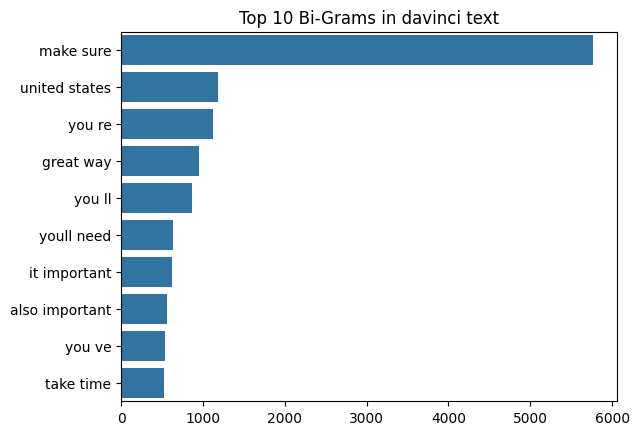

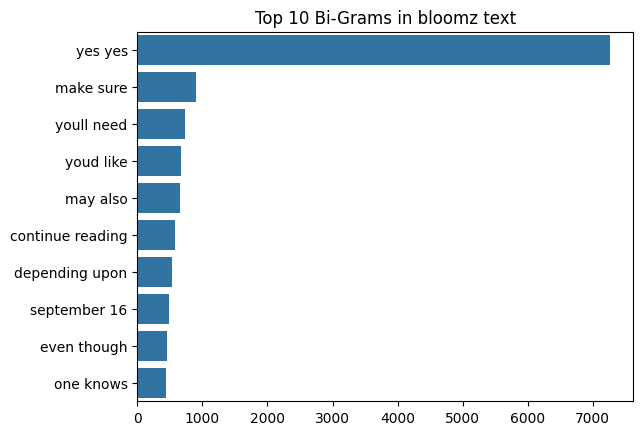

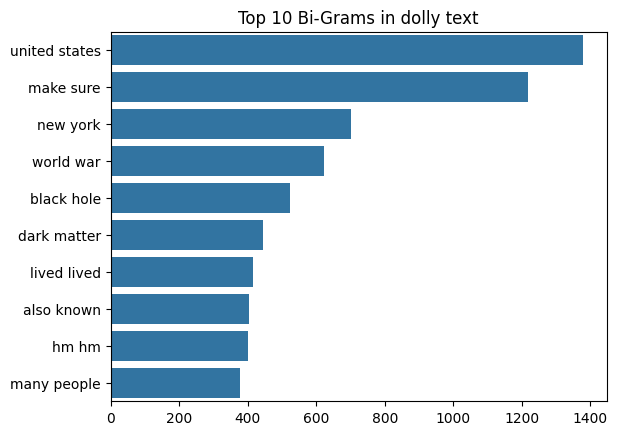

In [156]:
# Bi-gram analysis
for i in train_data['model'].unique():
  plot_top_ngrams_barchart(train_data[train_data['model']==i]['stopwords_removed'],i, 2)

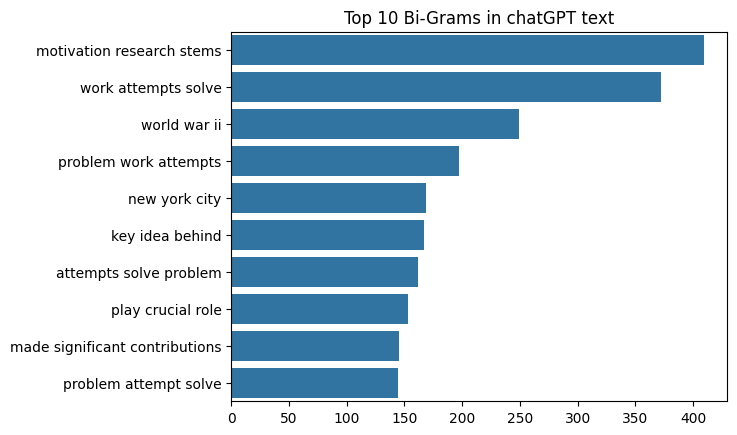

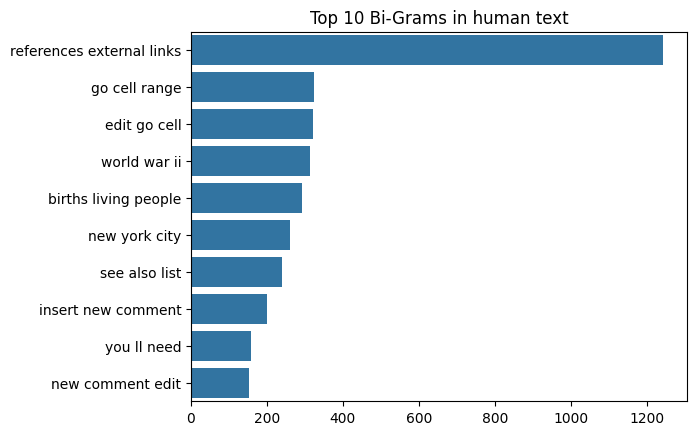

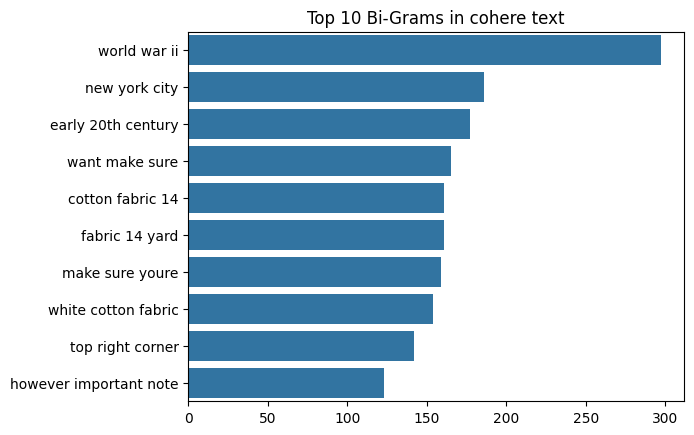

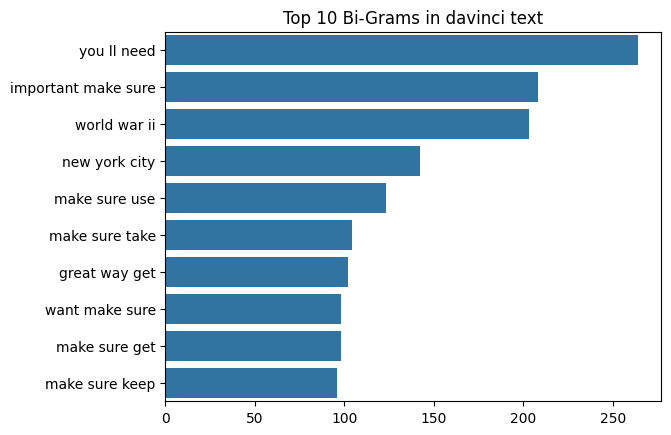

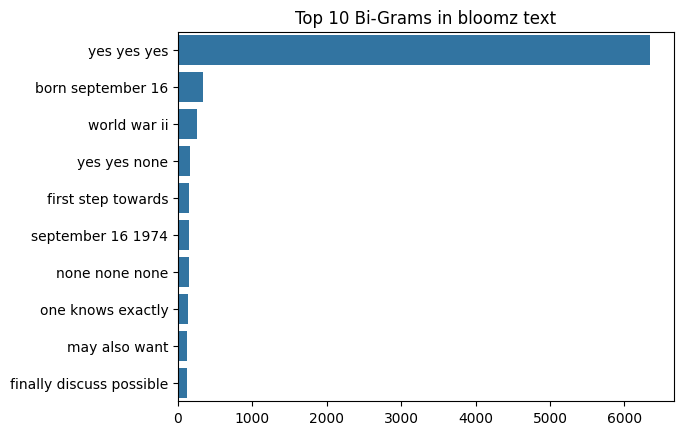

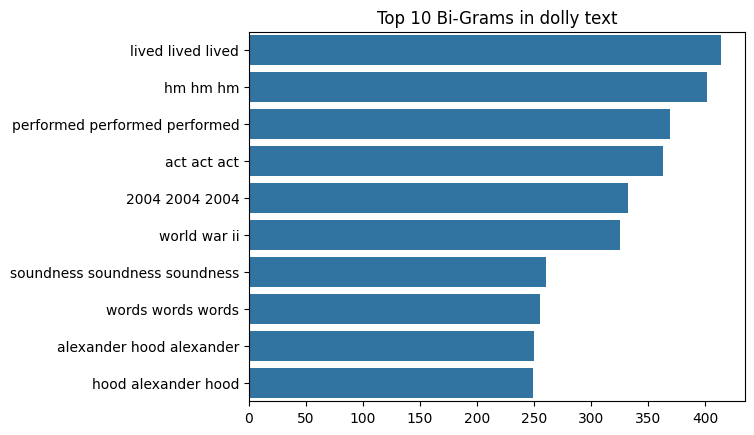

In [157]:
# Tri-gram analysis
for i in train_data['model'].unique():
  plot_top_ngrams_barchart(train_data[train_data['model']==i]['stopwords_removed'],i, 3)

In [ ]:
words = train_data['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
len(allwords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14005151

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


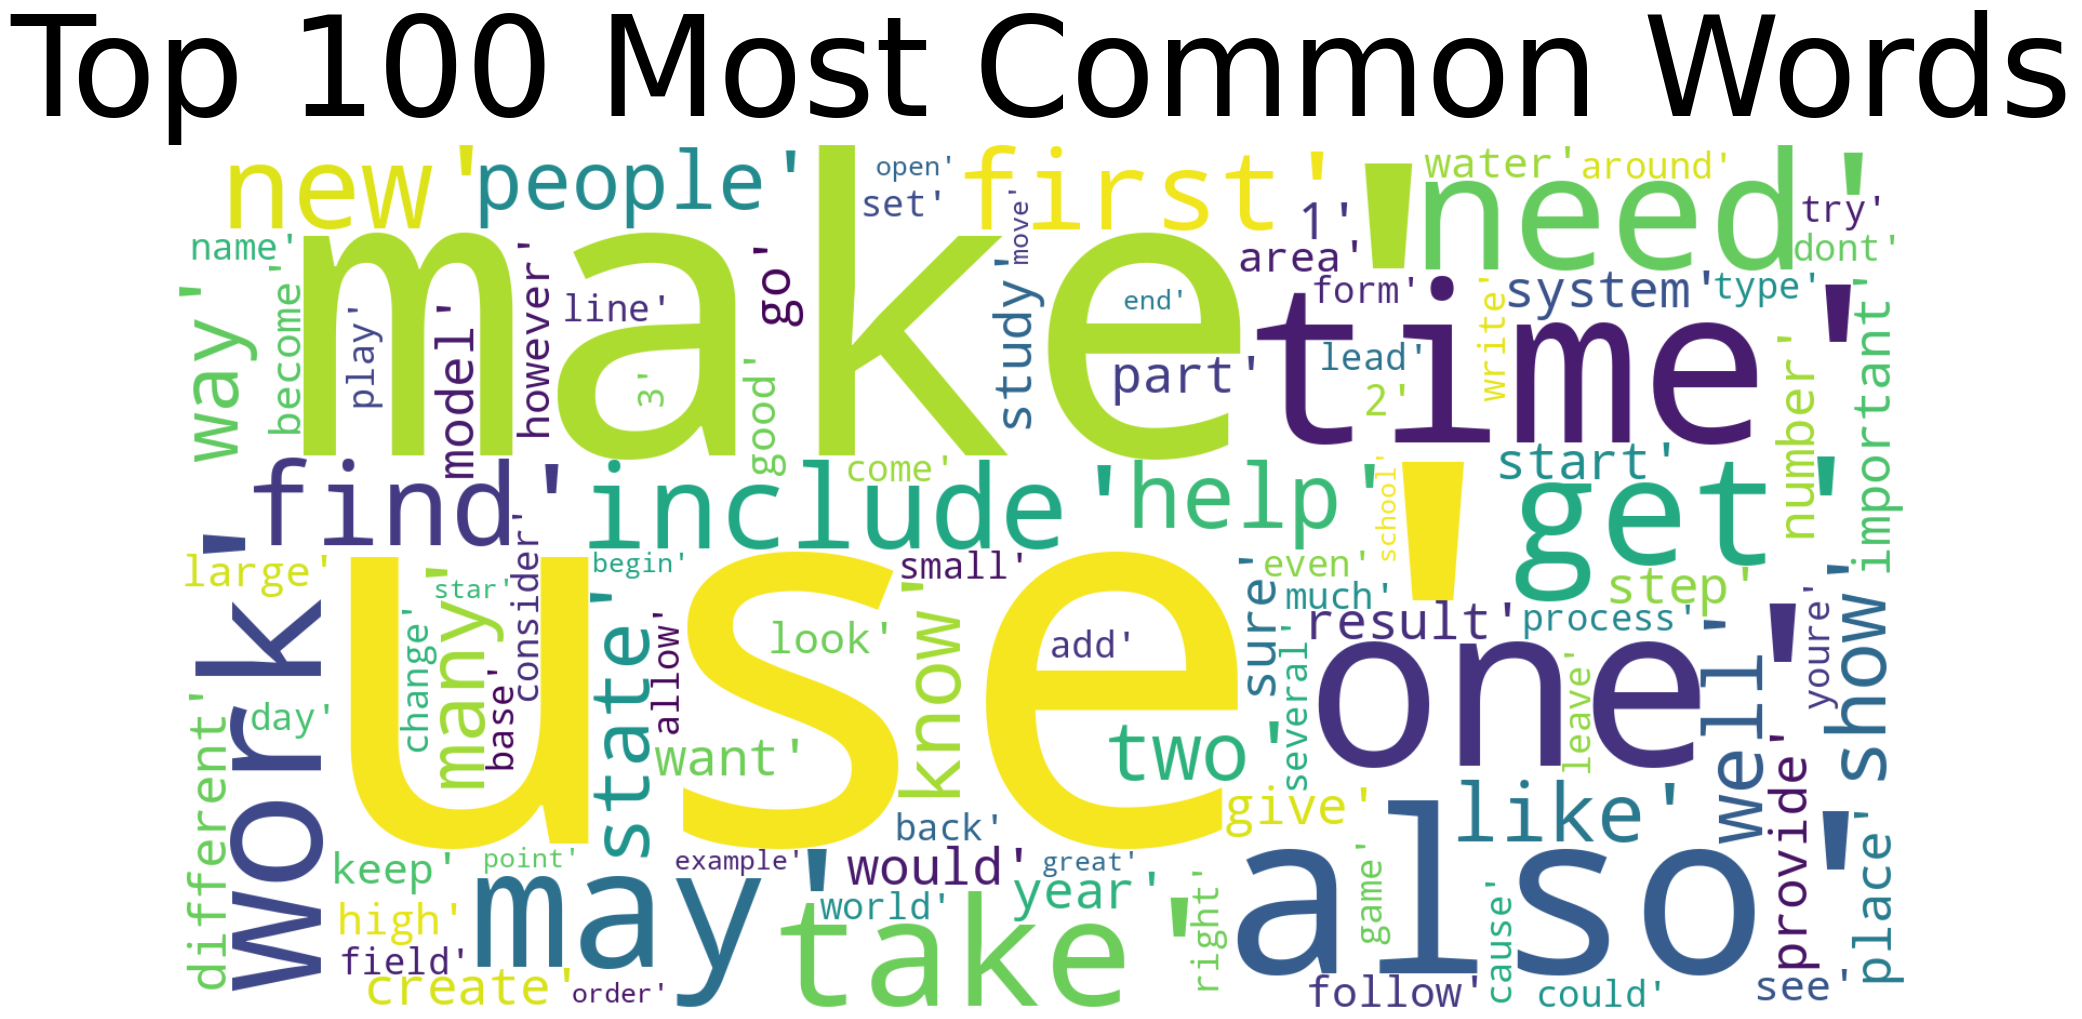

In [ ]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


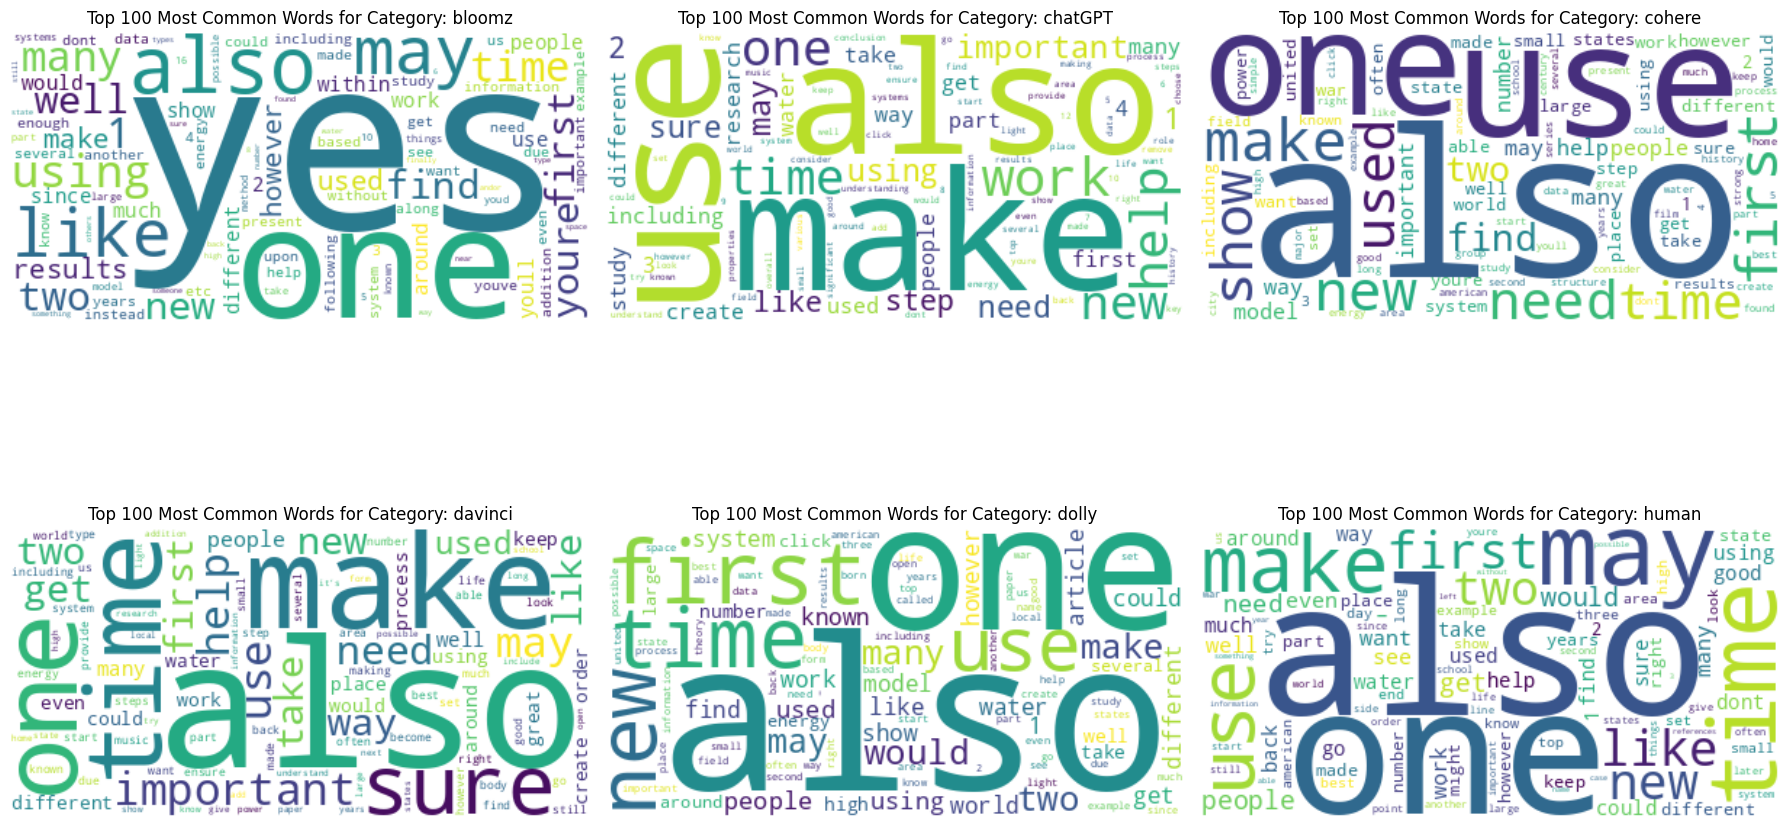

In [ ]:
grouped = train_data.groupby('model')['stopwords_removed'].apply(list)
categories = grouped.index
num_rows = 2
num_cols = 3
total_plots = num_rows * num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axs = axs.flatten()

for i, (category, words) in enumerate(grouped.items()):
    if i >= total_plots:
        break

    allwords = []
    for wordlist in words:
        allwords += wordlist

    mostcommon_category = Counter(allwords).most_common(100)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(dict(mostcommon_category))
    axs[i].imshow(wordcloud, interpolation="bilinear")
    axs[i].set_title(f'Top 100 Most Common Words for Category: {category}')
    axs[i].axis('off')

for i in range(len(categories), total_plots):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-29-b677bed9f959>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(words, rotation=60, fontsize=10)


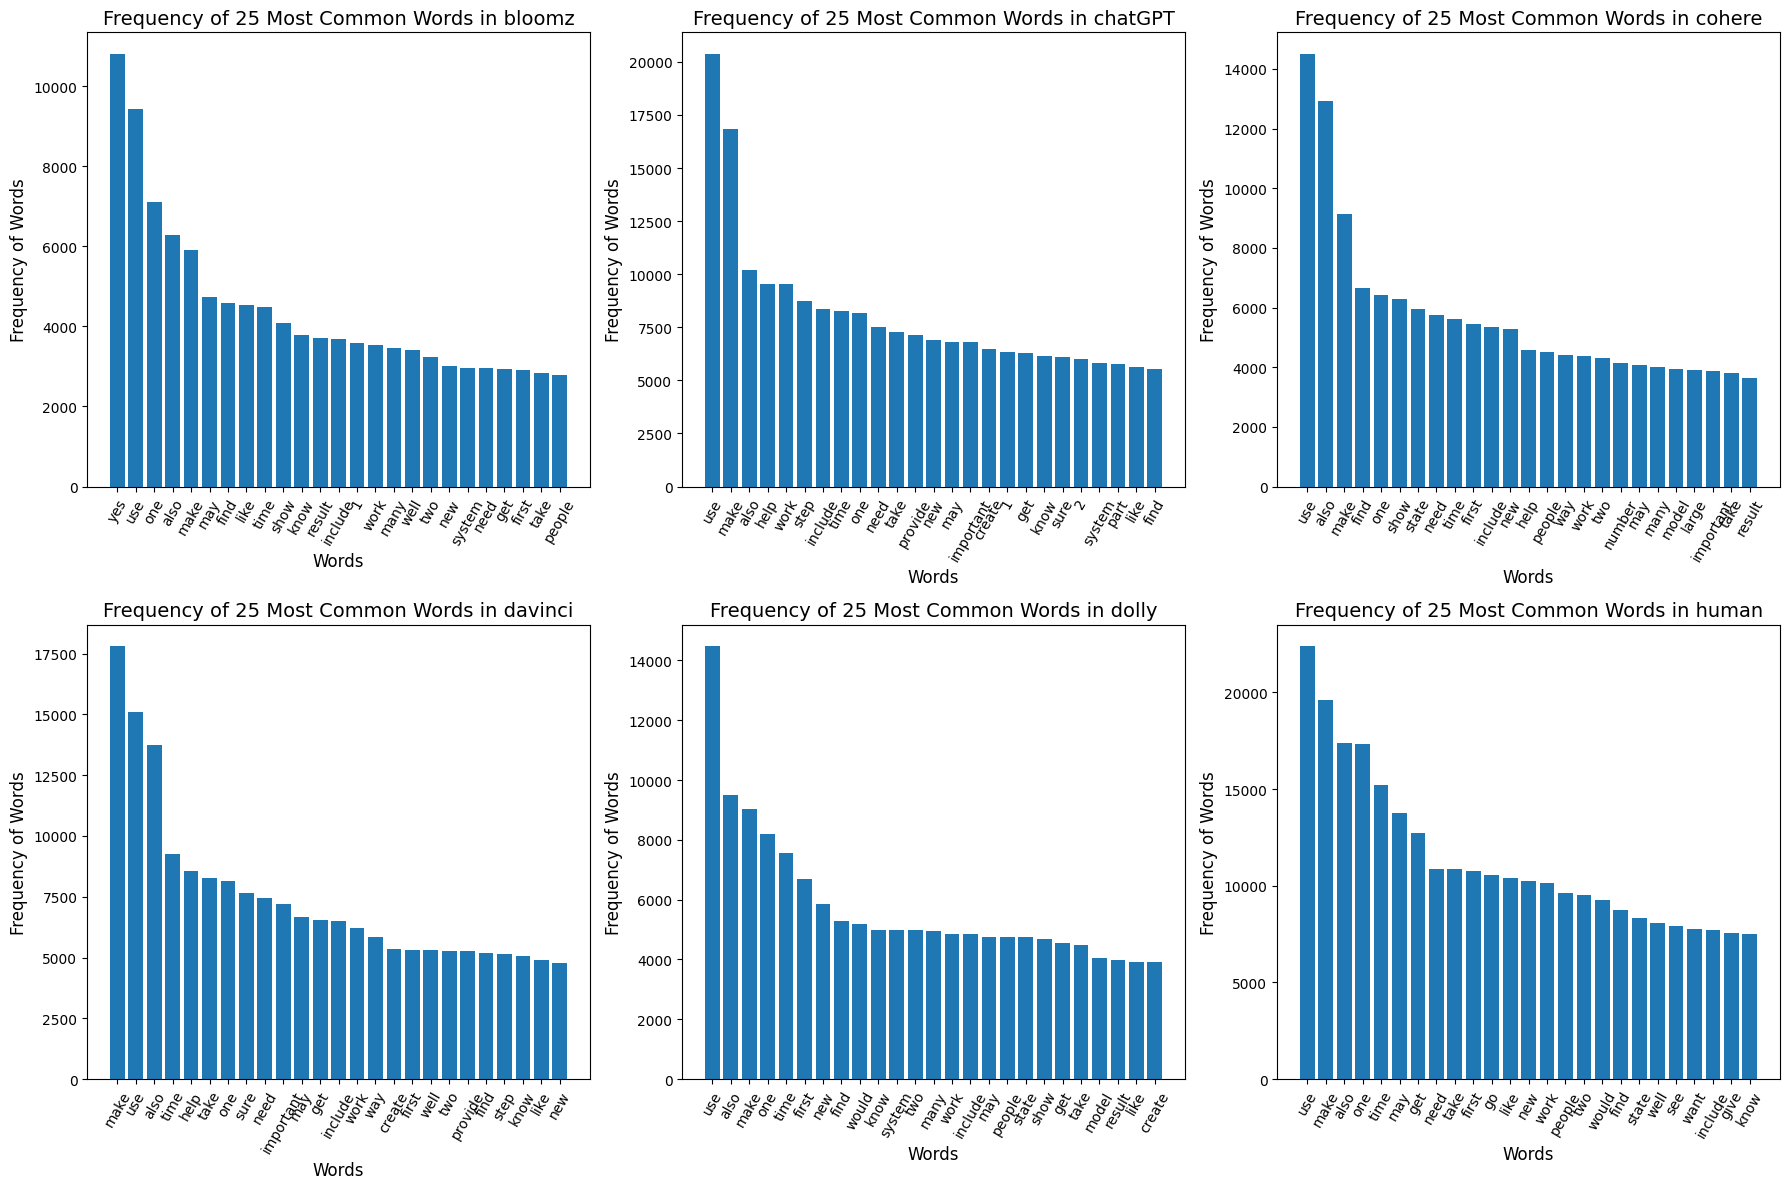

In [ ]:
group_by = train_data.groupby('model')['lemma_str'].apply(lambda x: Counter(''.join(x).split()).most_common(25))
categories = group_by.index
num_rows = 2
num_cols = 3
total_plots = num_rows * num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axs = axs.flatten()
for i, category in enumerate(categories):
    if i >= total_plots:
        break
    category_data = group_by[category]
    words = list(zip(*category_data))[0]
    freq = list(zip(*category_data))[1]

    axs[i].bar(words, freq)
    axs[i].set_xlabel('Words', fontsize=12)
    axs[i].set_ylabel('Frequency of Words', fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=10)
    axs[i].set_xticklabels(words, rotation=60, fontsize=10)
    axs[i].set_title(f'Frequency of 25 Most Common Words in {category}', fontsize=14)

for i in range(len(categories), total_plots):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# Topic Modelling:

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(train_data['lemma_str'].values)#.values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,01,02,03,05,10,100,1000,10000,11,12,...,youll,young,youre,youth,youtube,youve,zealand,zero,zip,zone
0,0,0,0,0,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,2,0,0,0,1,1,...,2,0,3,0,0,2,0,0,0,0
2,0,0,0,0,1,0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,6,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
nmf_models = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def lda_for_category(category_data):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(category_data)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))

    nmf = NMF(n_components=10, random_state=0, init='nndsvd').fit(tfidf)

    no_top_words = 10
    def display_topics(model, feature_names, no_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print("Topic %d:" % (topic_idx))
            print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

    print("\nTopics for this category:")
    display_topics(nmf, tfidf_feature_names, no_top_words)
    nmf_models.append(nmf)

grouped = train_data.groupby('model')['lemma_str'].apply(list)

for category, data in grouped.items():
    print(f"\n\nNMF for Category: {category}")
    lda_for_category(data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




NMF for Category: bloomz

Topics for this category:
Topic 0:
get know people make thing go dont like try someone
Topic 1:
yes none choice one know true didnt maybe answer happen
Topic 2:
model result study theory show system field state use quantum
Topic 3:
september bear 16 1974 play football former born mayor team
Topic 4:
galaxy star cluster mass observation result emission data find present
Topic 5:
use create step make youll need start file youve youre
Topic 6:
war world name part country include city state france river
Topic 7:
cause body water blood cell brain food human damage also
Topic 8:
district village county population census province iran romanize persian rural
Topic 9:
specie genus family describe name moth plant marine snail sea


NMF for Category: chatGPT

Topics for this category:
Topic 0:
may help body water child food cause take brain sleep
Topic 1:
model system quantum theory study behavior field work research property
Topic 2:
work university art award include 

In [ ]:
import pyLDAvis.lda_model
import numpy as np
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(nmf_models[0], np.matrix(doc_term_matrix).toarray(), tf_vectorizer, mds='tsne')
panel

MemoryError: Unable to allocate 2.65 GiB for an array with shape (71027, 5000) and data type int64